<div style='text-align:center;'>
    <h1>HopSurfer</h1>
</div>

<h2>Dependencies</h2>

In [1]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

import numpy as np
import scipy.sparse as sparse
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.sparse import lil_matrix
from scipy.sparse import csc_matrix
from collections import defaultdict
from sklearn.preprocessing import normalize
import networkx as nx

<h2>Datasets</h2>

In [ ]:
##############################################################################
# DATA: AS MATRICES
##############################################################################

### STRUCTURE
S = csr_matrix(np.array([[0, 1, 1, 0],
                         [1, 0, 0, 1],
                         [1, 0, 0, 0],
                         [0, 1, 0, 0]]))

### TRANSITIONS
T = csr_matrix(np.array([[0, 10,10, 0],
                         [10, 0, 0,10],
                         [10, 0, 0, 0],
                         [0, 10, 0, 0]]))

In [2]:
##############################################################################
# DATA: AS GRAPHS
##############################################################################

### STRUCTURE
G=nx.DiGraph()
G.add_edge('a','y')
G.add_edge('a','m')
G.add_edge('y','y')

### TRANSITIONS
H=nx.DiGraph()
H.add_edge('a','y',weight=10)
H.add_edge('a','m',weight=5)
H.add_edge('m','y',weight=1)

### TO UNDIRECTED
tmp = nx.Graph()
tmp.add_edges_from(H.edges(), weight=0)
for u, v, d in H.edges(data=True):
    tmp[u][v]['weight'] += d['weight']
H = tmp

### ADJACENCY MATRICES
S = nx.adjacency_matrix(G.to_undirected(),['y','a','m'])
T = nx.adjacency_matrix(H,['y','a','m'])

<h2>Functions and Methods</h2>

In [3]:
##############################################################################
# AIC
##############################################################################
def AIC(loglikelihood, params):
    return (-2 * loglikelihood) + (2 * params)

In [4]:
##############################################################################
# RANDOM WALK
##############################################################################

def random_walk_likelihood(structure, transitions, alpha=0.85):
    params = []
    if alpha is not None and (alpha < 0 or alpha > 1):
        raise ValueError("damping factor must be between 0 and 1 (inclusive).")
        return None, None

    params = [alpha]
    N = structure.shape[0]
    ### rows and columns that matter (where there is a link and transitions)
    nnz = structure.multiply(transitions)
    nnz = sparse.find(nnz)
    ### probability of following sructure: alpha / outlinks
    if alpha > 0:
        P = csr_matrix((alpha * structure) / structure.sum(axis=1))
        ### only cells that matter
        P = P[nnz[0],nnz[1]]
        ### adding teleportation
        P += (1-alpha) / N
    else:
        ### adding teleportation
        P = (1-alpha) * structure[nnz[0],nnz[1]] / N
    ### log-likelihood
    l = (transitions[nnz[0],nnz[1]].A1 * np.log(P.A1)).sum()
    return l,params

In [5]:
##############################################################################
# HOP RANK
##############################################################################

def hop_counts(structure):
    hops = csr_matrix(structure.shape, dtype=np.int16)
    previous_hops = None
    
    hop = 1
    structure.setdiag(0)
    m = structure.copy()

    for r,row in enumerate(structure):
        hops[r,row.indices] = hop
        
    while m.sum() > 0:
        
        if previous_hops is None:
            previous_hops = m.copy()
        else:
            previous_hops += m
    
        m = lil_matrix(m.dot(structure))
        m.setdiag(0)
        m -= previous_hops
        m = (m>0).astype(np.int8)
        m.eliminate_zeros()
        
        hop += 1
        for r,row in enumerate(m):
            hops[r,row.indices] = hop

    hops.setdiag(0) 
    return hops

def hop_alphas(transitions, hops):    
    maxhops = int(hops.max())
    total = transitions.sum()
    alphas = np.zeros(maxhops)
    counts = np.zeros(maxhops)
    
    for hop in range(maxhops):
        transitions_in_hop = np.any(hops==hop+1).astype(np.int8).multiply(transitions)
        counts[hop] = transitions_in_hop.sum()
        alphas[hop] = transitions_in_hop.sum() / total
        
    return alphas, counts

def hop_surfer_likelihood(structure, transitions):
    hops = hop_counts(structure)
    alphas, counts = hop_alphas(transitions, hops)
    l = 1.0
    for r, row in enumerate(transitions):
        if row.sum() > 0:
            lrow = csr_matrix(np.take(alphas,hops[r].data-1)[row.indices],dtype=np.float)
            l += (row.data * np.log(lrow.data)).sum()
    return l,alphas

In [6]:
##############################################################################
# MARKOV CHAIN
##############################################################################

def markov_chain_likelihood(structure, transitions):
    P = normalize(transitions,'l1',axis=1)
    l = (transitions.data * np.log(P.data)).sum()
    params = sparse.find(P.tocsr())[2].tolist()
    return l,params

In [7]:
##############################################################################
# VIZ
##############################################################################

def plot_graph(G, title, ax=None, pos=None):
    
    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=(3,3))
        
    if pos is None:
        pos = nx.spring_layout(G)  # positions for all nodes

    # nodes
    nx.draw_networkx_nodes(G, pos, node_size=700, ax=ax)

    # edges
    edges = [(u, v, d) for (u, v, d) in G.edges(data=True)]
    nx.draw_networkx_edges(G, pos, edgelist=[(u,v) for (u, v, d) in edges], width=[d['weight'] if 'weight' in d else 2 for (u, v, d) in edges], ax=ax)

    # labels
    nx.draw_networkx_labels(G, pos, font_size=20, font_family='sans-serif', ax=ax)

    ax.axis('off')
    ax.set_title(title.upper())
    return pos

<h2>Experiments and Results</h2>

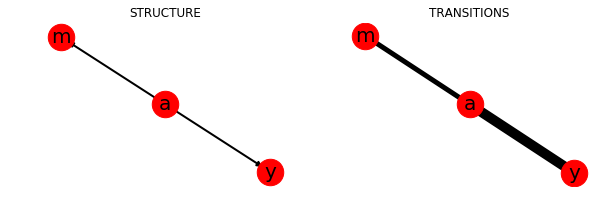

In [8]:
##############################################################################
# Data Vizualization
##############################################################################
fig, axes = plt.subplots(1,2,figsize=(10,3))
pos = plot_graph(G,'structure',axes[0])
_ = plot_graph(H,'transitions',axes[1],pos)

In [9]:
##############################################################################
# LOG-LIKELIHOODS
##############################################################################

### RANDOM WALK: 0.0 (never teleporting, always following links)
alpha = 0.
l,params = random_walk_likelihood(S,T,alpha)
aic = AIC(l,len(params))
print('random walk {}: \n- likelihood: {}\n- AIC: {}\n'.format(params,l,aic))

### RANDOM WALK: 1.0 (always teleporting)
alpha = 1.
l,params = random_walk_likelihood(S,T,alpha)
aic = AIC(l,len(params))
print('random walk {}: \n- likelihood: {}\n- AIC: {}\n'.format(params,l,aic))

### RANDOM WALK: 0.85 (teleporting 85% of the time)
alpha = 0.85
l,params = random_walk_likelihood(S,T,alpha)
aic = AIC(l,len(params))
print('random walk {}: \n- likelihood: {}\n- AIC: {}\n'.format(params,l,aic))

### RANDOM WALK: 0.15 (teleporting 15% of the time)
alpha = 0.15
l,params = random_walk_likelihood(S,T,alpha)
aic = AIC(l,len(params))
print('random walk {}: \n- likelihood: {}\n- AIC: {}\n'.format(params,l,aic))

### MARKOV CHAIN
l,params = markov_chain_likelihood(S,T)
aic = AIC(l,len(params))
print('markov chain {}: \n- likelihood: {}\n- AIC: {}\n'.format(params,l,aic))

### HOPSURFER
l,params = hop_surfer_likelihood(S,T)
aic = AIC(l,len(params))
print('hop rank {}: \n- likelihood: {}\n- AIC: {}\n'.format(params,l,aic))

random walk [0.0]: 
- likelihood: -32.9583686600433
- AIC: 67.9167373200866

random walk [1.0]: 
- likelihood: -17.328679513998633
- AIC: 36.657359027997266

random walk [0.85]: 
- likelihood: -19.13781445197653
- AIC: 40.27562890395306

random walk [0.15]: 
- likelihood: -29.838530798215185
- AIC: 61.67706159643037

markov chain [0.6666666666666666, 0.16666666666666666, 0.9090909090909091, 0.8333333333333334, 0.09090909090909091, 0.3333333333333333]: 
- likelihood: -15.60207684846164
- AIC: 43.204153696923285

hop rank [0.9375 0.0625]: 
- likelihood: -6.481333078606697
- AIC: 16.962666157213395



/ssd/lespin/virtualenv/python3.5/lib/python3.5/site-packages/scipy/sparse/compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)
